In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [22]:
train_transform_a = transforms.Compose([
        transforms.GaussianBlur((3,3)),     
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

train_transform_b = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

train_transform_c = transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [91]:
root = '../Data/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train')) #, transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

trainset_a, trainset_b, trainset_c = torch.utils.data.random_split(train_data, [6247, 6247, 6249])

# we assign the .dataset of our subset to be equal to the subset iself
# in other words trainset has the correct images (6247), trainset.dataset references the parent dataset, which is
# about 18000 images long. We dont want any reference to the parent data set. I think?
# trainset_a.dataset = trainset_a
# trainset_b.dataset = trainset_b
# trainset_c.dataset = trainset_c

# print(len(trainset_a.dataset))
# print(len(trainset_b))
# print(len(trainset_c))

# We Split the train set into 3 subsets, then apply a transformation to each of these subsets.
# This will serve as a way to "simulate" federated learning (a.k.a multiple users with their own data set and transformation)
trainset_a.dataset.transform = train_transform_a
trainset_b.dataset.transform = train_transform_b
trainset_c.dataset.transform = train_transform_c

torch.manual_seed(42)

# List where we will store our 3 different subsets
list_of_datasets = []

# We then append the data sets to the list
list_of_datasets.append(trainset_a.dataset)
list_of_datasets.append(trainset_b.dataset)
list_of_datasets.append(trainset_c.dataset)

# Loading our test set
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

# Concatinate our list of data sets
merged_train_data = ConcatDataset(list_of_datasets)
# Then load our data (notice we need to shuffle!)
merged_train_loader = DataLoader(merged_train_data, batch_size=10, shuffle=True)

# merged_train_set_loader = DataLoader(merged_train_data, batch_size=10, shuffle=True)
class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(merged_train_data)}')
print(f'Testing images available:  {len(test_data)}')
print(type(test_loader))
print(type(merged_train_set_loader))

['CAT', 'DOG']
Training images available: 56229
Testing images available:  6251
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


Label: [1 1 1 1 0 1 0 0 1 1]
Class: DOG DOG DOG DOG CAT DOG CAT CAT DOG DOG


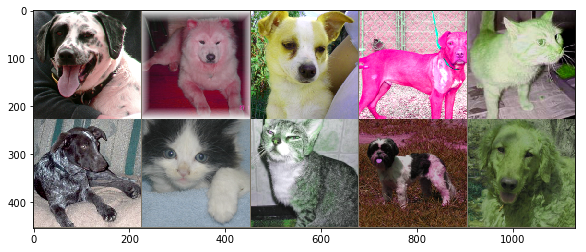

In [92]:
# Grab the first batch of 10 images
for images,labels in merged_train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [9]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


In [10]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.77983063  accuracy:  57.800%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.51571345  accuracy:  61.400%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.50562775  accuracy:  62.117%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.48489887  accuracy:  63.087%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.51793706  accuracy:  70.000%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.80166948  accuracy:  70.350%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.41254324  accuracy:  70.633%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.72434211  accuracy:  70.300%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.49738583  accuracy:  73.050%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.66624522  accuracy:  72.550%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.93357354  accuracy:  73.000%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.82573682  accuracy:  73.213%

Duration: 376 seconds
